In [ ]:
#import libraries
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2


mount drive

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


load the digit model which was trained (from Digit.ipynb file)

In [ ]:
model_path = '/content/drive/MyDrive/Digit_CVPR/digit_minst_cnn_model.h5'

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully!")



Model loaded successfully!


load test data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


evaluate the model for test

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.3f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9914 - loss: 0.0271
Test Accuracy: 99.240%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


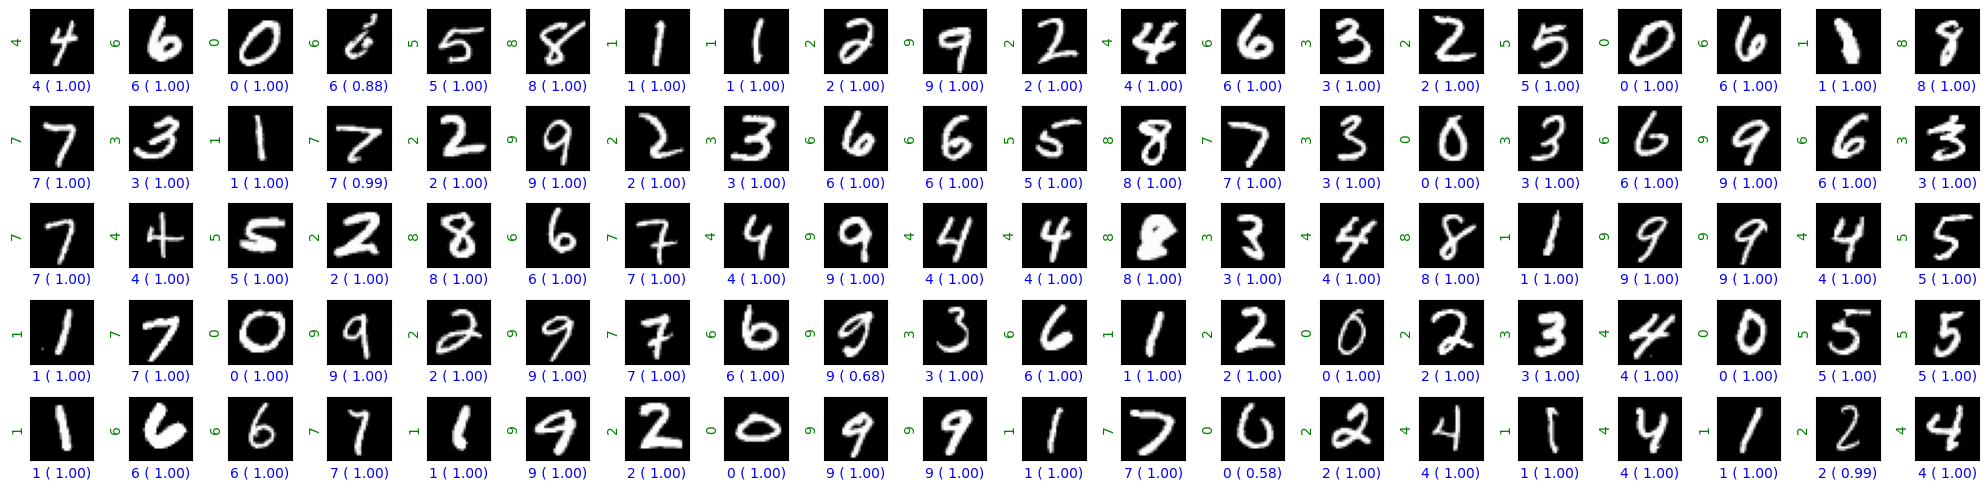

In [ ]:

ROWS = 5
COLS = 20

random_indices = random.sample(range(x_test.shape[0]), ROWS*COLS)
sample_images = x_test[random_indices, :]
sample_labels = y_test[random_indices]
predictions = model.predict(sample_images)

i = 0

plt.figure(figsize=(20,5))
for r in range(ROWS):
    for c in range(COLS):
        plt.subplot(ROWS, COLS, i+1)
        plt.imshow(sample_images[i].reshape(28,28), cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        prediction = np.argmax(predictions[i])
        confidence = predictions[i][prediction]
        if sample_labels[i] == prediction:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='b')
        else:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='r')
        plt.ylabel(sample_labels[i], color='g')
        i += 1

plt.tight_layout()
plt.show()

In [99]:



# Load trained CNN model ---
model = load_model("/content/drive/MyDrive/Digit_CVPR/digit_minst_cnn_model.h5")

# Preprocessing function
def preprocess_and_detect_digit(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Median blur to reduce noise
    blurred = cv2.medianBlur(gray, 5)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 3)

    # Morphological closing
    kernel_close = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    # Strong dilation to bold the digit
    kernel_dilate = np.ones((4, 4), np.uint8)
    morph_bold = cv2.dilate(morph, kernel_dilate, iterations=3)

    # Find contours
    contours, _ = cv2.findContours(morph_bold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 150]

    if len(contours) == 0:
        return None, None, None

    # Get largest contour
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Crop digit
    digit_crop = morph_bold[y:y+h, x:x+w]

    # Pad to square without resizing
    max_side = max(w, h)
    square = np.zeros((max_side, max_side), dtype=np.uint8)
    x_offset = (max_side - w) // 2
    y_offset = (max_side - h) // 2
    square[y_offset:y_offset+h, x_offset:x_offset+w] = digit_crop

    # Resize to 28x28
    digit_resized = cv2.resize(square, (28, 28), interpolation=cv2.INTER_NEAREST)

    # Normalize and enhance contrast
    digit_resized = cv2.normalize(digit_resized, None, 0, 255, cv2.NORM_MINMAX)
    digit_resized = cv2.equalizeHist(digit_resized)

    return digit_resized, (x, y, w, h), morph_bold


#  Prediction pipeline
def predict_digit(img):
    digit_resized, bbox, processed = preprocess_and_detect_digit(img)
    if digit_resized is None:
        print("No digit detected.")
        return

    # Prepare for model
    digit_norm = digit_resized.astype("float32") / 255.0
    digit_input = np.expand_dims(digit_norm, axis=(0, -1))  # (1,28,28,1)

    # Predict
    pred = model.predict(digit_input)
    label = np.argmax(pred)
    confidence = np.max(pred)

    # Show results
    x, y, w, h = bbox
    img_boxed = img.copy()
    cv2.rectangle(img_boxed, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_boxed, f"{label} ({confidence:.2f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title("Original + Box"); plt.imshow(cv2.cvtColor(img_boxed, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2); plt.title("Processed"); plt.imshow(processed, cmap="gray")
    plt.subplot(1, 3, 3); plt.title("Final 28x28"); plt.imshow(digit_resized, cmap="gray")
    plt.show()

    return label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


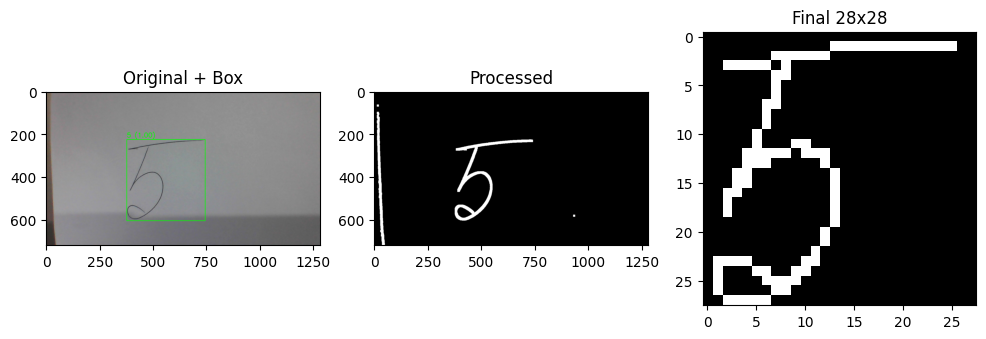

(np.int64(5), np.float32(0.9992131))

In [100]:
# Load one image from drive
img = cv2.imread("/content/drive/MyDrive/WIN_20250825_04_52_43_Pro.jpg")

# Run prediction
predict_digit(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


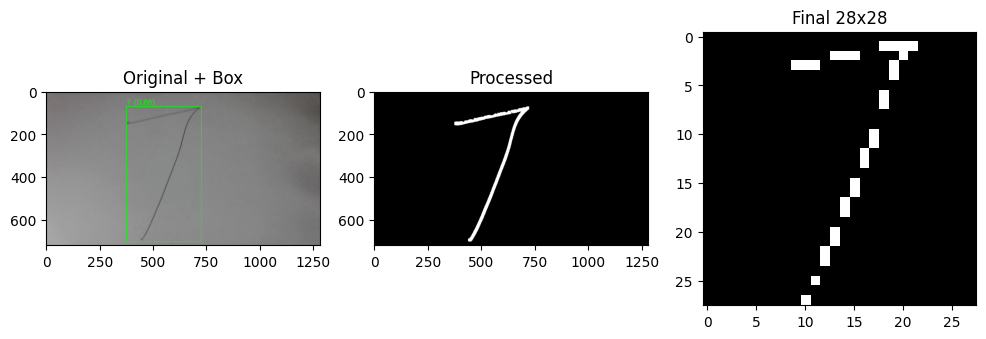

(np.int64(7), np.float32(0.86371267))

In [102]:
# Load one image from drive
img = cv2.imread("/content/drive/MyDrive/WIN_20250825_04_54_39_Pro.jpg")

# Run prediction
predict_digit(img)


In [107]:
#Capturing real time photo
from google.colab.output import eval_js
from base64 import b64decode
import IPython.display
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = f"""
    async function takePhoto(quality) {{
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Take Photo1';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({{video: true}});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
    }}
    takePhoto({quality});
    """
    display(IPython.display.Javascript(js))
    data = eval_js(f"takePhoto({quality})")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename



Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


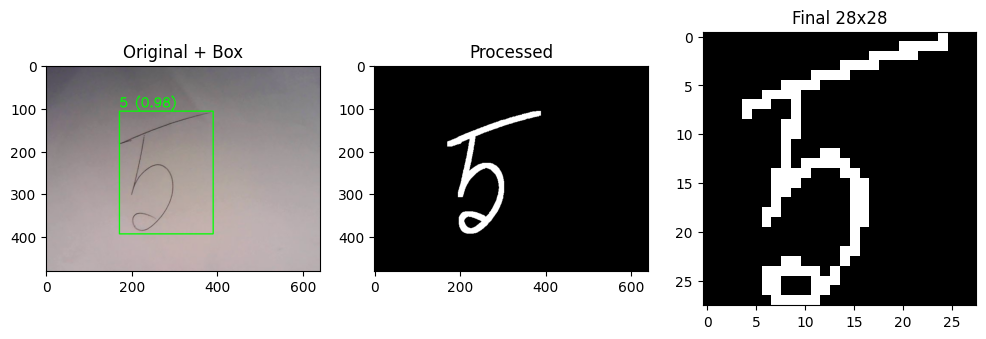

✅ Prediction: 5 (confidence: 0.98)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


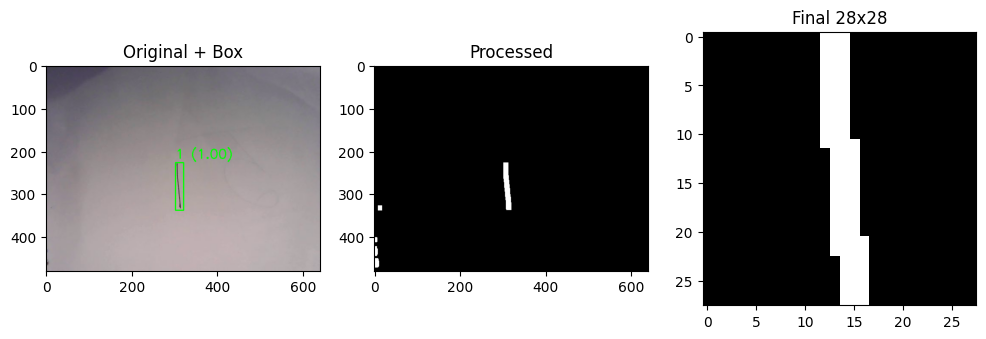

✅ Prediction: 1 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


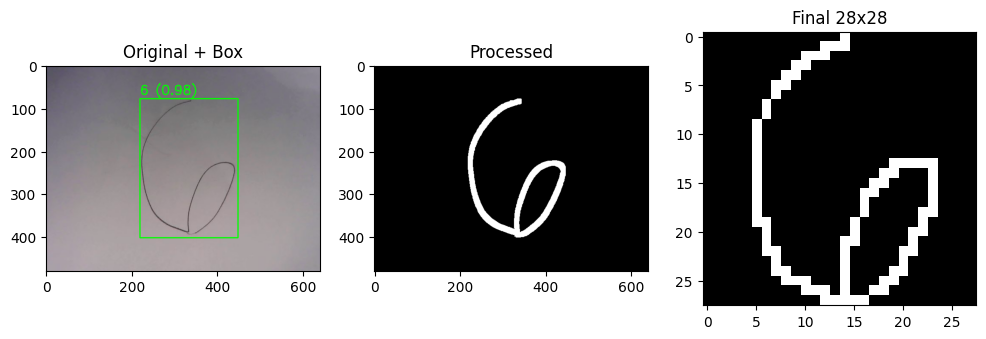

✅ Prediction: 6 (confidence: 0.98)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


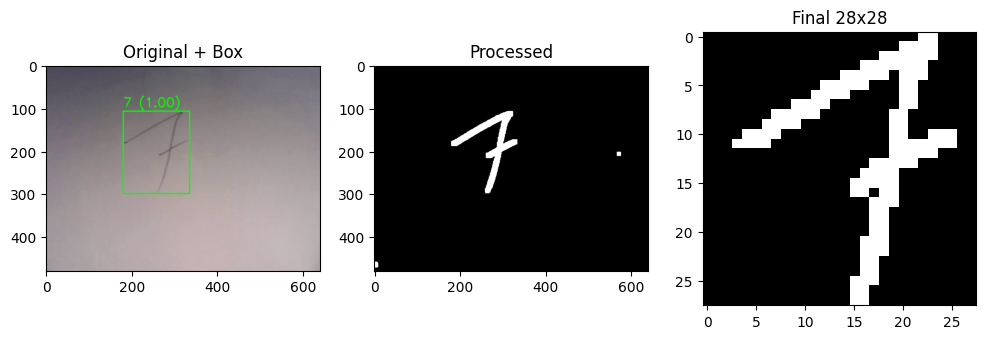

✅ Prediction: 7 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


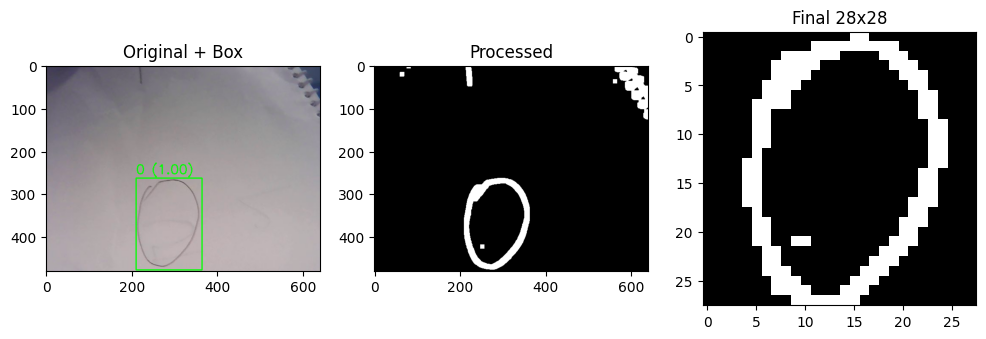

✅ Prediction: 0 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


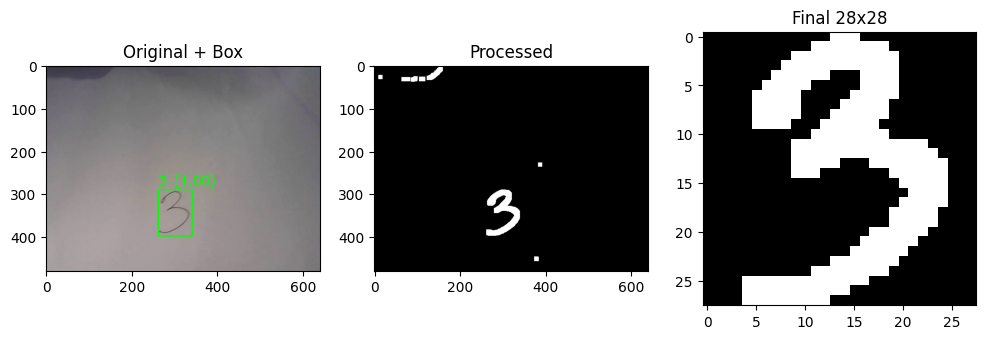

✅ Prediction: 3 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


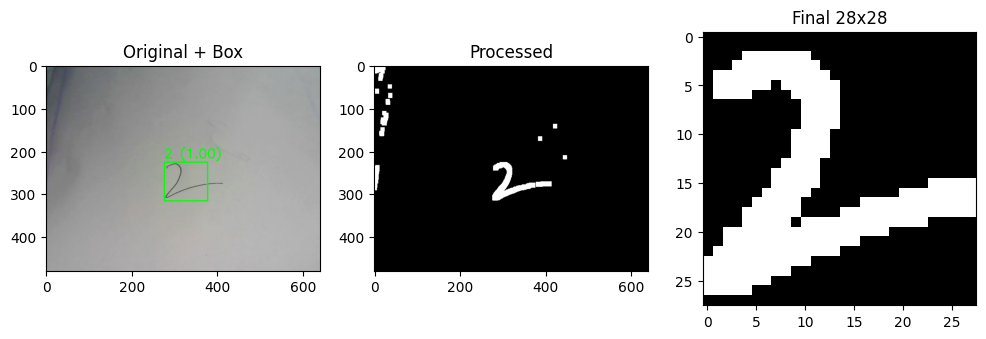

✅ Prediction: 2 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


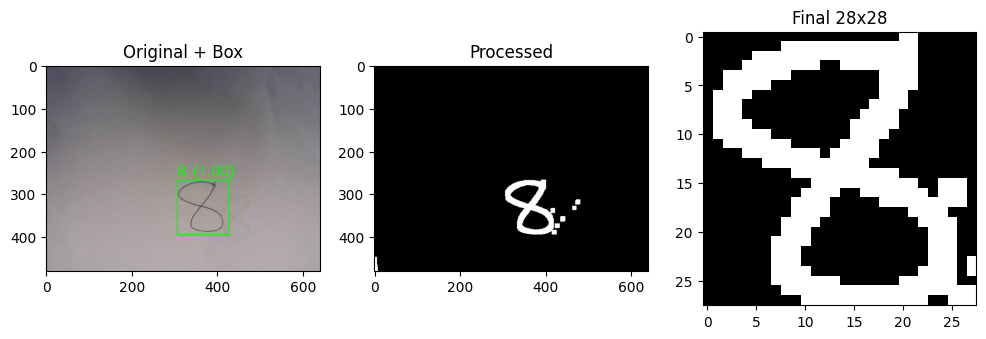

✅ Prediction: 8 (confidence: 1.00)
Capture another? (y/n): y
Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


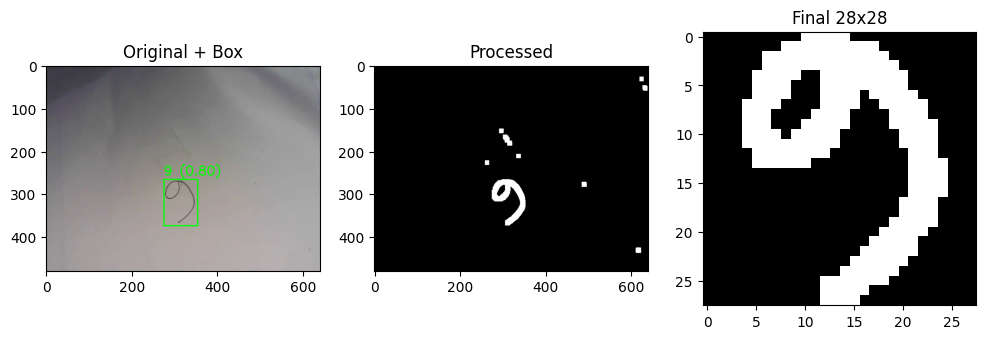

✅ Prediction: 9 (confidence: 0.80)
Capture another? (y/n): n


In [110]:
while True:
    print("Click '📸 Take Photo' to capture. (Stop the loop by pressing the Colab stop button)")
    photo_filename = take_photo()
    img = cv2.imread(photo_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = predict_digit(img)

    if result is None:
        print("❌ No digit found.")
    else:
        label, confidence = result
        print(f"✅ Prediction: {label} (confidence: {confidence:.2f})")

    # Ask if user wants another capture
    again = input("Capture another? (y/n): ").strip().lower()
    if again != "y":
        break
